In [141]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize

In [13]:
data = pd.read_json('song.json', orient='records')
data['time_played'] = pd.to_datetime(data['time_played'])
data['user_sign_up_date'] = pd.to_datetime(data['user_sign_up_date'])
data.head()

,id,user_id,user_state,user_sign_up_date,song_played,time_played
0,GOQMMKSQQH,122,Louisiana,2015-05-16,Hey Jude,2015-06-11 21:51:35
1,HWKKBQKNWI,3,Ohio,2015-05-01,We Can Work It Out,2015-06-06 16:49:19
2,DKQSXVNJDH,35,New Jersey,2015-05-04,Back In the U.S.S.R.,2015-06-14 02:11:29
3,HLHRIDQTUW,126,Illinois,2015-05-16,P.s. I Love You,2015-06-08 12:26:10
4,SUKJCSBCYW,6,New Jersey,2015-05-01,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00


In [14]:
data.isnull().sum()

id                   0
user_id              0
user_state           0
user_sign_up_date    0
song_played          0
time_played          0
dtype: int64

In [20]:
for name in data.columns:
    print(name, len(data[name].unique()))

id 4000
user_id 196
user_state 41
user_sign_up_date 20
song_played 100
time_played 3997


# Q1 Top 3 and Bottom 3 states in terms of users

In [50]:
def unique_count(x):
    return len(np.unique(x))

In [71]:
user = data.groupby('user_state')['user_id'].apply(unique_count).reset_index()
user = user.rename(columns={'user_id': 'user_count'})
user.head()

,user_state,user_count
0,Alabama,4
1,Alaska,2
2,Arizona,1
3,Arkansas,2
4,California,21


In [73]:
user.sort_values(by = 'user_count', ascending = False)[:3]

,user_state,user_count
25,New York,23
4,California,21
35,Texas,15


In [74]:
user.sort_values(by = 'user_count', ascending = True)[:3]

,user_state,user_count
2,Arizona,1
24,New Mexico,1
6,Connecticut,1


<AxesSubplot:xlabel='user_state', ylabel='count'>

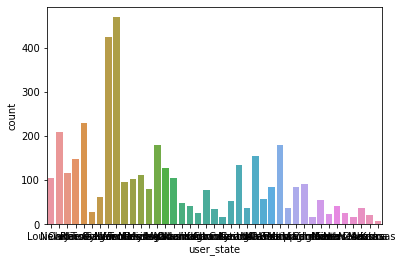

In [75]:
sns.countplot(x = 'user_state',data = data)

# Q2

What are the top 3 and the bottom 3 states in terms of user engagement? You can
choose how to mathematically define user engagement. What the CEO cares about here
is in which states users are using the product a lot/very little



User engagement score = avg plays of song 
per user in any state

In [76]:
song = data.groupby(['user_state'])['id'].count().reset_index()
song = song.rename(columns={'id': 'song_count'})

In [83]:
engagement = pd.concat([user['user_count'], song], axis = 1)
engagement['avg song per user'] = engagement['song_count']/engagement['user_count']
engagement.head()

,user_count,user_state,song_count,avg song per user
0,4,Alabama,104,26.000000
1,2,Alaska,58,29.000000
2,1,Arizona,22,22.000000
3,2,Arkansas,34,17.000000
4,21,California,425,20.238095


In [84]:
engagement.sort_values(by = 'avg song per user', ascending = False)[:3]

,user_count,user_state,song_count,avg song per user
22,1,Nebraska,36,36.000000
1,2,Alaska,58,29.000000
20,3,Mississippi,85,28.333333


In [85]:
engagement.sort_values(by = 'avg song per user', ascending = True)[:3]

,user_count,user_state,song_count,avg song per user
13,1,Kansas,8,8.0
37,2,Virginia,17,8.5
19,4,Minnesota,42,10.5


# Q3 
The CEO wants to send a gift to the first user who signed-up for each state. That is, the
first user who signed-up from California, from Oregon, etc. Can you give him a list of
those users?

In [110]:
data['user_sign_up_date'].idxmin()

1

In [129]:
signupfirst_df = data.groupby(['user_state']).apply(lambda x: x.loc[x.user_sign_up_date.idxmin()])

signupfirst_df[['user_id', 'user_sign_up_date']]

,user_id,user_sign_up_date
user_state,,
Alabama,5,2015-05-01
Alaska,106,2015-05-12
Arizona,105,2015-05-12
Arkansas,78,2015-05-08
California,39,2015-05-04
Colorado,173,2015-05-19
Connecticut,127,2015-05-16
Florida,41,2015-05-04
Georgia,20,2015-05-02


# Q4
Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.

Collaborative filtering

In [142]:
sim_song = data.groupby(['song_played', 'user_id'])['id'].count().unstack(fill_value = 0)
sim_song.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,0,0,1,3,0,2,0,0,0,0,...,0,0,3,3,0,2,0,0,2,0
A Hard Day's Night,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
A Saturday Club Xmas/Crimble Medley,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANYTIME AT ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Across The Universe,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# Consine Similarity, higher the number, the more similar the song gets between each other

In [166]:
cos_sim_df = cosine_similarity(sim_song, sim_song)

In [169]:
similarity_df = pd.DataFrame(cos_sim_df, index=sim_song.index, columns=sim_song.index)
similarity_df.head()

song_played,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,BALLAD OF JOHN AND YOKO,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,1.000000,0.235702,0.074536,0.119523,0.212132,0.355023,0.329404,0.152145,0.210819,0.172133,...,0.464938,0.030429,0.508964,0.223607,0.359092,0.037268,0.318198,0.353220,0.087841,0.0
A Hard Day's Night,0.235702,1.000000,0.000000,0.000000,0.100000,0.136931,0.111803,0.000000,0.000000,0.091287,...,0.259548,0.129099,0.210099,0.000000,0.000000,0.000000,0.050000,0.195468,0.074536,0.0
A Saturday Club Xmas/Crimble Medley,0.074536,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.109435,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
ANYTIME AT ALL,0.119523,0.000000,0.000000,1.000000,0.000000,0.154303,0.094491,0.109109,0.000000,0.000000,...,0.116991,0.000000,0.138107,0.089087,0.183942,0.000000,0.000000,0.146845,0.000000,0.0
Across The Universe,0.212132,0.100000,0.000000,0.000000,1.000000,0.091287,0.000000,0.000000,0.000000,0.000000,...,0.138426,0.000000,0.116722,0.000000,0.000000,0.000000,0.000000,0.043437,0.000000,0.0


In [173]:
def find_topk(song, similarity, k=1):
    df = similarity.loc[song].sort_values(ascending=False)[1:k + 1].reset_index()
    df = df.rename(columns={'song_played': 'Song', song: 'Similarity'})
    
    return df

In [183]:
df = find_topk(song='Eight Days A Week', similarity=similarity_df, k=5)

df

,Song,Similarity
0,Hey Jude,0.399035
1,Come Together,0.392338
2,Let It Be,0.388770
3,Penny Lane,0.375534
4,A Day In The Life,0.348639


# Q5

Conduct A/B testing

Control group: without our recommandation system in Q4

Experiment group: with our reommandaation system in Q4

after running the experiment, we collect the feedback or data from the two groups

Null hypothesis: H0: no difference between the two groups in terms of recommandation

Alternative hypothesis: H1: experiment group has higher engagement score than the control group.

We could use one-tail t-test on the engagement score